In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
# Extras
from matplotlib.patches import FancyArrowPatch

In [2]:
# Get cpu, gpu or mps device for training.
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # Use the first CUDA device
else:
    device = torch.device("cpu")  # Fallback to CPU

print(f"Using {device} device")
torch.cuda.get_device_name(0)

Using cuda:0 device


'NVIDIA GeForce RTX 3050 Ti Laptop GPU'

# Projection functions and testing

* ## Primal Projection Methods

In [3]:
import torch

def softmax(matrix,axis = None,T=1):
    exp_matrix = torch.exp(matrix/T - torch.max(matrix, dim=axis, keepdim=True).values)
    softmax_matrix = exp_matrix / torch.sum(exp_matrix, dim=axis, keepdim=True)
    return softmax_matrix


def normalize_axis(to_normalize, axis=None):
    axis_sum = torch.sum(to_normalize, dim=axis, keepdim=True)
    
    # Normalize only if the sum is greater than 1
    if torch.any(axis_sum > 1):
        return to_normalize / axis_sum
    return to_normalize


def normalize_matrix_axis(matrix,axis = None):
    slices = [normalize_axis(to_normalize=matrix.select(axis, i), axis=None) for i in range(matrix.size(axis))]
    return torch.stack(slices, dim=axis)


def get_axis_sums(matrix,axis = None):
    return torch.sum(matrix, dim=axis)


def primal_projection(matrix,axis = None):
    ret_mat = normalize_matrix_axis(matrix = softmax(matrix = matrix,axis = axis),axis = axis).clone()
    r = get_axis_sums(ret_mat,axis = 1)
    c = get_axis_sums(ret_mat,axis = 0)
    r_tild = torch.ones(len(ret_mat), device=matrix.device) - r
    c_tild = torch.ones(len(ret_mat[0]), device=matrix.device) - c
    ret_mat = ret_mat + (1 / torch.sum(c_tild)) * torch.outer(r_tild, c_tild)
    return ret_mat

# Example usage
matrix = torch.tensor(data = [[1,3,5],[4,3,2],[5,3,35]])  # Example random matrix
projected_matrix = primal_projection(matrix = matrix, axis = 0) # Row example
print("Original matrix:")
print(matrix)
print("\nProjected matrix:")
print(projected_matrix)


Original matrix:
tensor([[ 1,  3,  5],
        [ 4,  3,  2],
        [ 5,  3, 35]])

Projected matrix:
tensor([[0.2426, 0.4393, 0.3180],
        [0.4063, 0.3984, 0.1953],
        [0.3511, 0.1622, 0.4867]])


* ## Dual Projection Methods
* - Non symmetric version

In [4]:
def dual_projection(f, g, cost):
    """
    Perform dual projection to obtain f_ret and g_ret.
    
    Parameters:
    f (torch.Tensor): A 1D tensor with the f values.
    g (torch.Tensor): A 1D tensor with the g values.
    cost (torch.Tensor): A 2D tensor with cost values where cost[i][k] is the cost value.

    Returns:
    torch.Tensor: f_ret tensor.
    torch.Tensor: g_ret tensor.
    """
    # Compute g_ret (which is simply g)
    g_ret = g.clone()
    
    # Compute the cost matrix subtraction
    cost_minus_g = cost - g.unsqueeze(1)  # Broadcasting to subtract g from each column in cost
    
    # Compute min_over_k(cost[i][k] - g[k])
    min_cost_minus_g = torch.min(cost_minus_g, dim=1).values
    
    # Compute f_ret
    f_ret = torch.minimum(f, min_cost_minus_g)
    
    return f_ret, g_ret

# Example usage
f = torch.tensor([10.0, 20.0, 30.0], dtype=torch.float32)
g = torch.tensor([1.0, 2.0, 3.0], dtype=torch.float32)
cost = torch.tensor([[4.0, 5.0, 6.0],
                     [7.0, 8.0, 9.0],
                     [10.0, 11.0, 12.0]], dtype=torch.float32)

f_ret, g_ret = dual_projection(f, g, cost)
print("f_ret:", f_ret)
print("g_ret:", g_ret)


f_ret: tensor([3., 5., 7.])
g_ret: tensor([1., 2., 3.])


# Actual Data Generating Process 

In [5]:
def generate_vector_batches(count: int, dim: int, n: int, device: torch.device, coord_max: float, seed: int = 42):
    """
    Generates a single tensor with shape (count, 2, n, dim) on the specified device,
    with each coordinate having values in the range [-coord_max, coord_max].
    
    Parameters:
    count (int): Number of batches to generate.
    dim (int): Dimension of each vector.
    n (int): Number of vectors in each batch.
    device (torch.device): The device on which to create the tensors.
    coord_max (float): The maximum absolute value for each coordinate.
    seed (int, optional): Random seed for reproducibility.
    
    Returns:
    torch.Tensor: A tensor with shape (count, 2, n, dim), with values in the range [-coord_max, coord_max].
    """
    
    if seed is not None:
        torch.manual_seed(seed)
    
    # Generate random values in the range [-coord_max, coord_max]
    batches = (2 * torch.rand((count, 2, n, dim), device=device) - 1) * coord_max
    
    return batches

# Example usage:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
coord_max = 10.0
batches = generate_vector_batches(count=3, dim=5, n=4, device=device, coord_max=coord_max, seed=42)

for i in range(batches.size(0)):
    print(f"Batch {i+1}:")
    print(batches[i])
    print(batches[i].shape)
    print()


Batch 1:
tensor([[[ 2.2592, -9.7988, -2.0317, -9.1938, -6.8747],
         [-0.3505,  4.7249, -1.8804,  0.3780, -4.2658],
         [-5.1684,  8.4568,  6.5983, -9.3162, -2.2421],
         [-8.3522,  5.4836, -4.4156,  0.2767, -5.8636]],

        [[-9.8527,  7.5006,  9.3644, -7.5977, -6.0559],
         [-0.9949, -8.9777, -0.2158,  8.6620, -2.3851],
         [-8.9830, -4.6750,  2.9892, -4.6503, -6.5341],
         [ 7.1294, -4.4773, -5.8144, -8.5785,  5.4023]]], device='cuda:0')
torch.Size([2, 4, 5])

Batch 2:
tensor([[[ 2.1998, -3.1125,  9.7038, -0.6165,  8.4068],
         [ 4.2547, -7.8968,  6.2767, -7.8162,  2.1988],
         [-6.4988,  6.8130,  7.4095,  4.5738, -4.9187],
         [-6.6656,  4.5402, -2.0261, -4.6084,  6.0591]],

        [[-1.7817, -7.0508, -9.5433, -5.3377, -5.4033],
         [-2.0324, -0.3833, -3.7556,  2.4402, -2.8781],
         [ 3.0226,  8.6095, -4.6067, -9.0785,  9.8505],
         [-4.4235,  0.2146,  1.8899,  2.3293, -3.4174]]], device='cuda:0')
torch.Size([2, 4, 5])

# Wasserstein Distance verification

* Reset Device to gpu

In [6]:
# Get cpu, gpu or mps device for training.
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # Use the first CUDA device
else:
    device = torch.device("cpu")  # Fallback to CPU

print(f"Using {device} device")
torch.cuda.get_device_name(0)

Using cuda:0 device


'NVIDIA GeForce RTX 3050 Ti Laptop GPU'

In [7]:
import itertools

def wass_permutations(batch, device):
    """
    Given two lists of d-dimensional vectors, each of size n, computes the Wasserstein p=2 distance between them.
    
    This distance is found by checking every possible permutation of vector couplings and selecting the one 
    that minimizes the sum of squared distances between corresponding vectors.
    
    Parameters:
    - batch: tensor of shape (2, n, d), where batch[0] and batch[1] are the two sets of n vectors to be compared.
    - device: 'cpu' or 'cuda' for GPU computation.
    
    Returns:
    - Wasserstein distance (p=2) between the two sets of vectors.
    """
    # Move batch to specified device (CPU or GPU)
    batch = batch.to(device)
    
    vectors1 = batch[0]
    vectors2 = batch[1]
    n = vectors1.shape[0]

    # Generate all permutations of size n
    all_permutations = list(itertools.permutations(range(n)))

    min_squared_distance = float('inf')

    # Loop over all permutations
    for perm in all_permutations:
        # Create an index tensor for the current permutation
        perm_tensor = torch.tensor(perm, device=device)

        # Compute the squared distance for this permutation
        squared_distance_sum = torch.sum((vectors1 - vectors2[perm_tensor]) ** 2)

        # Update minimum distance
        if squared_distance_sum < min_squared_distance:
            min_squared_distance = squared_distance_sum.item()  # Convert to Python float for comparison

    # Return the Wasserstein distance (sqrt of minimum squared distance)
    return torch.sqrt(torch.tensor(min_squared_distance, device=device))


## Sanity check 
* Should get sqrt(29) = 5.3852

In [8]:
vectors1 = torch.tensor([
    [1.0, 0.0, 0.0],  # e1
    [0.0, 1.0, 0.0],  # e2
    [0.0, 0.0, 1.0]   # e3
])

# Second set: {e1, 2e2, 3e3}
vectors2 = torch.tensor([
    [1.0, 0.0, 0.0],  # e1
    [0.0, 6.0, 0.0],  # 6e2
    [0.0, 0.0, 3.0]   # 3e3
])

batch = torch.stack([vectors1, vectors2])

# Calculate the Wasserstein distance
distance = wass_permutations(batch,device = device)
print("Wasserstein distance:", distance)


Wasserstein distance: tensor(5.3852, device='cuda:0')


In [9]:
from scipy.optimize import linear_sum_assignment

def wass_hungarian(batch):
    """
    Given two sets of d-dimensional vectors, each of size n, computes the Wasserstein p=2 distance between them.
    
    This distance is found by using the Hungarian algorithm to find the optimal matching 
    that minimizes the sum of squared distances between corresponding vectors.
    
    Parameters:
    - batch: tensor of shape (2, n, d), where batch[0] and batch[1] are the two sets of n vectors to be compared.
    
    Returns:
    - Wasserstein distance (p=2) between the two sets of vectors.
    """
    
    # Extract the two sets of vectors
    vectors1 = batch[0]  # Shape: (n, d)
    vectors2 = batch[1]  # Shape: (n, d)

    # Compute the squared Euclidean distance matrix using broadcasting
    distance_matrix = torch.sum((vectors1[:, None, :] - vectors2[None, :, :]) ** 2, dim=-1)

    # Use the Hungarian algorithm to find the optimal assignment
    row_ind, col_ind = linear_sum_assignment(distance_matrix.cpu().numpy())

    # Calculate the total minimum distance
    min_squared_distance = distance_matrix[row_ind, col_ind].sum()

    # Return the Wasserstein distance (p=2)
    return torch.sqrt(min_squared_distance)


## Timing each method

In [10]:
import time

seed = 16
count = 1000
dim = 10
n = 4
coordinate_max = 5
batches = generate_vector_batches(count=count,
                                            dim=dim,
                                            n=n, 
                                            device=device,
                                            seed=seed,
                                            coord_max=coordinate_max)



In [11]:
# O(n!*n)
# Time the permutations implementation
start_time = time.time()
for i in range(batches.shape[0]):
    wass_permutations(batches[i],device=device)

print("Time taken (permutations):", time.time() - start_time)

Time taken (permutations): 4.227373838424683


In [12]:
# O(n^3)
# Time the Hungarian implementation
start_time = time.time()

for i in range(batches.shape[0]):
    wass_hungarian(batches[i])

print("Time taken (Hungarian):", time.time() - start_time)


Time taken (Hungarian): 0.26575398445129395


# Primal Dual solution bounds 

In [13]:
def compute_distance_matrix(vecs1, vecs2):
    """
    Computes the pairwise distance matrix between two sets of vectors.

    Parameters:
    - vecs1: Tensor of shape (n, d), where n is the number of vectors and d is the dimension of each vector.
    - vecs2: Tensor of shape (n, d), where m is the number of vectors and d is the dimension of each vector.

    Returns:
    - distance_matrix: Tensor of shape (n, n), where each element [i, j] represents the Euclidean distance between vecs1[i] and vecs2[j].
    """
    # Compute the pairwise distance matrix using torch.cdist (Euclidean distance by default)
    distance_matrix = torch.cdist(vecs1, vecs2, p=2)
    
    return distance_matrix


* Generating toy batch

In [14]:
vectors1 = torch.tensor([
    [1.0, 0.0, 0.0],  # e1
    [0.0, 1.0, 0.0],  # e2
    [0.0, 0.0, 1.0]   # e3
])

# Second set: {e1, 2e2, 3e3}
vectors2 = torch.tensor([
    [1.0, 0.0, 0.0],  # e1
    [0.0, 1.0, 0.0],  #1e2
    [0.0, 0.0, 3.0]   # 3e3
])

batch = torch.stack([vectors1, vectors2])

# Calculate the Wasserstein distance
distance = wass_permutations(batch,device=device)
print("Wasserstein distance:", distance)
distances_mat = compute_distance_matrix(vecs1=vectors1,vecs2 = vectors2)
print("Distances matrix: ")
print(distances_mat)

Wasserstein distance: tensor(2., device='cuda:0')
Distances matrix: 
tensor([[0.0000, 1.4142, 3.1623],
        [1.4142, 0.0000, 3.1623],
        [1.4142, 1.4142, 2.0000]])


In [15]:
def primal_sol(out_put_mat,distances_mat):
    # Flatten the matrices
    bi_stoch_mat = primal_projection(out_put_mat,axis = 0)
    B = bi_stoch_mat.view(-1)
    D = (distances_mat**2).view(-1)
    
    # Compute the dot product of the flattened matrices
    dot_product = torch.dot(B, D)
    return torch.sqrt(dot_product)


def dual_projection(f, g, cost):
    """
    Perform dual projection to obtain f_ret and g_ret.
    
    Parameters:
    f (torch.Tensor): A 1D tensor with the f values.
    g (torch.Tensor): A 1D tensor with the g values.
    cost (torch.Tensor): A 2D tensor with cost values where cost[i][k] is the cost value.

    Returns:
    torch.Tensor: f_ret tensor.
    torch.Tensor: g_ret tensor.
    """

    
    # Compute g_ret (which is simply g)
    f_ret = f.clone()
    
    # Compute the cost matrix subtraction
    cost_minus_f = cost - g.unsqueeze(1)  # Broadcasting to subtract g from each column in cost
    
    g_ret = torch.min(cost_minus_f, dim=0).values
    
    return f_ret, g_ret

def dual_sol(f, g, distances_mat):
    projected_f, projected_g = dual_projection(f=f, g=g, cost=(distances_mat**2))  # Changed distances to squared
    sum_result = torch.sum(projected_f + projected_g)
    max_val = torch.maximum(sum_result, torch.tensor(0.0))  # Take the max of the sum and zero
    return torch.sqrt(max_val) 
    

In [16]:
seed = 42
torch.manual_seed(seed)

out_matrix = torch.rand(3, 3)
f = torch.rand(3)
g = torch.rand(3)
distances_mat = compute_distance_matrix(vecs1=vectors1,vecs2 = vectors2)
sol_prim = primal_sol(out_put_mat=out_matrix,distances_mat=distances_mat)
sol_dual = dual_sol(f=f,g=g,distances_mat=distances_mat) 

In [17]:
print(f"Dual solution {sol_dual}")
print(f"actual value {distance}")
print(f"Primal solution {sol_prim}")

Dual solution 1.8663198947906494
actual value 2.0
Primal solution 3.182631015777588


In [18]:
def random_check(distances_mat, actual_distance, n=1000):
    prim_sols = torch.ones(n)
    dual_sols = torch.ones(n)
    device = distances_mat.device

    for i in range(n):
        out_matrix = torch.rand(3, 3, device=device)  # Ensure the tensor is created on the specified device
        f = torch.rand(3, device=device)
        g = torch.rand(3, device=device)
        
        sol_prim = primal_sol(out_put_mat=out_matrix, distances_mat=distances_mat)
        sol_dual = dual_sol(f=f, g=g, distances_mat=distances_mat) 
        
        prim_sols[i] = sol_prim
        dual_sols[i] = sol_dual 

    # Calculate max dual and min primal solutions
    max_dual = dual_sols.max().item()
    min_prim = prim_sols.min().item()

    # Plotting the results
    plt.figure(figsize=(12, 6))

    # Scatter plot for dual solutions
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.scatter(range(n), dual_sols.cpu(), color='blue', alpha=0.6)
    plt.title('Dual Solutions')
    plt.xlabel('Index')
    plt.ylabel('Dual Solution Value')
    plt.axhline(y=actual_distance.item(), color='red', linestyle='--', label='Actual Distance')
    plt.axhline(y=max_dual, color='purple', linestyle='--', label='Max Dual Solution')
    plt.legend()

    # Scatter plot for primal solutions
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.scatter(range(n), prim_sols.cpu(), color='green', alpha=0.6)
    plt.title('Primal Solutions')
    plt.xlabel('Index')
    plt.ylabel('Primal Solution Value')
    plt.axhline(y=min_prim, color='orange', linestyle='--', label='Min Primal Solution')
    plt.legend()

    plt.tight_layout()
    plt.show()


### Fair Enough we think ,Problem: this is for one sample

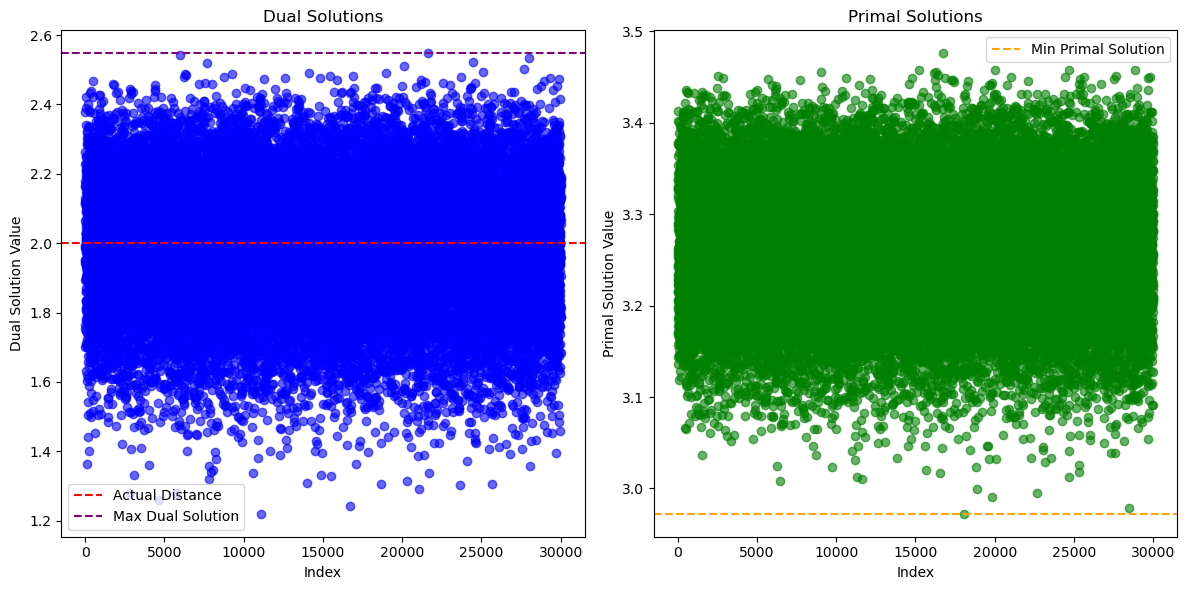

Time taken: 10.263387203216553


In [19]:
start_time = time.time()
random_check(distances_mat = distances_mat,actual_distance=distance, n = 30000)
print("Time taken:", time.time() - start_time)

### Checking if both methods are accurate to eachother up to numeric tolerance

In [20]:
def check_wasserstein_equivalence(batches, device, epsilon=1e-5):
    """
    Checks if the outputs of wass_permutations and wass_hungarian functions are the same 
    for a list of batches, up to a numeric tolerance of epsilon.

    Parameters:
    - batches: A list of input tensors, each of shape (2, n, d), for both functions.
    - device: The device on which to run the computation ('cpu' or 'cuda').
    - epsilon: Numeric tolerance for comparing the results.

    Returns:
    - True if all outputs are within the tolerance epsilon, False otherwise.
    """
    all_equivalent = True
    
    for idx, batch in enumerate(batches):
        # Move the batch to the specified device
        batch = batch.to(device)
        
        # Calculate wasserstein distance using both methods
        wass_perm_result = wass_permutations(batch, device)
        wass_hung_result = wass_hungarian(batch)
        
        # Compare the results up to the specified tolerance
        difference = torch.abs(wass_perm_result - wass_hung_result)
        
        if difference >= epsilon:
            print(f"Batch {idx}: Results differ by {difference.item()}, which is larger than epsilon = {epsilon}.")
            all_equivalent = False
    
    return all_equivalent

# Example usage:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seed = 16
count = 2000
dim = 6
n = 4
coordinate_max = 5
batches= generate_vector_batches(count=count,
                                            dim=dim,
                                            n=n, 
                                            device=device,
                                            seed=seed,
                                            coord_max=coordinate_max)

# Check if the two functions give equivalent results for all batches
epsilon = 1e-5
all_batches_equivalent = check_wasserstein_equivalence(batches, device,epsilon=epsilon)
print(f"For {epsilon} tolerance:")
if all_batches_equivalent:
    print("All batches produce equivalent results.")
else:
    print("Some batches produced differing results.")


For 1e-05 tolerance:
All batches produce equivalent results.


## Mass testing Dual solution

In [21]:
def stress_random_check(dual_sol_func,primal_sol_func,num_samples=100,trials_per_sample = 200):
    # Get cpu, gpu or mps device for training.
    if torch.cuda.is_available():
        device = torch.device("cuda:0")  # Use the first CUDA device
    else:
        device = torch.device("cpu")  # Fallback to CPU

    prim_sols = torch.ones(num_samples,trials_per_sample)
    dual_sols = torch.ones(num_samples,trials_per_sample)
    batches = generate_vector_batches(count = num_samples,dim=2,n=3,coord_max=10,device = device)
    fs = torch.ones(num_samples,trials_per_sample,3).to(device)
    gs = torch.ones(num_samples,trials_per_sample,3).to(device)
    foul_dual_params = []
    for i in range(num_samples):
        distances_mat = compute_distance_matrix(vecs1 = batches[i][0],vecs2 = batches[i][1])
        actual_distance = wass_hungarian(batches[i])
        for j in range(trials_per_sample):
            out_matrix = torch.rand(3, 3, device=device)  # Ensure the tensor is created on the specified device
            fs[i][j] = torch.rand(3, device=device)
            gs[i][j] = torch.rand(3, device=device)
        
            sol_prim = primal_sol_func(out_put_mat=out_matrix, distances_mat=distances_mat)
            sol_dual = dual_sol_func(f=fs[i][j], g=gs[i][j], distances_mat=distances_mat) 
            
            prim_sols[i][j] = sol_prim
            dual_sols[i][j] = sol_dual 

        # Calculate max dual and min primal solutions
        max_duals = dual_sols[i].max().item()
        min_prims = prim_sols[i].min().item()
        if(max_duals>actual_distance):
            print(f"Dual went over!, Max Dual sol ({max_duals}), Actual Distance ({actual_distance}),at index {dual_sols[i].argmax()}, difference:{max_duals-actual_distance}")
            foul_dual_params.append((fs[i][dual_sols[i].argmax()],
                                     gs[i][dual_sols[i].argmax()],
                                     actual_distance,
                                     max_duals,
                                     batches[i]))
    return foul_dual_params

In [22]:
fouls = stress_random_check(dual_sol_func=dual_sol,primal_sol_func=primal_sol)

Dual went over!, Max Dual sol (13.450063705444336), Actual Distance (13.392338752746582),at index 123, difference:0.057724952697753906
Dual went over!, Max Dual sol (12.038878440856934), Actual Distance (11.95438003540039),at index 130, difference:0.08449840545654297
Dual went over!, Max Dual sol (15.604032516479492), Actual Distance (15.54833984375),at index 183, difference:0.05569267272949219
Dual went over!, Max Dual sol (9.60605239868164), Actual Distance (9.504754066467285),at index 17, difference:0.10129833221435547
Dual went over!, Max Dual sol (8.303168296813965), Actual Distance (8.217667579650879),at index 35, difference:0.08550071716308594
Dual went over!, Max Dual sol (10.867874145507812), Actual Distance (10.787430763244629),at index 161, difference:0.0804433822631836
Dual went over!, Max Dual sol (6.760009288787842), Actual Distance (6.7096757888793945),at index 188, difference:0.050333499908447266
Dual went over!, Max Dual sol (4.833324909210205), Actual Distance (4.6292

In [23]:
fouls

[(tensor([0.8992, 0.8141, 0.9815], device='cuda:0'),
  tensor([0.7445, 0.2800, 0.1208], device='cuda:0'),
  tensor(13.3923, device='cuda:0'),
  13.450063705444336,
  tensor([[[ 2.2592, -9.7988],
           [-2.0317, -9.1938],
           [-6.8747, -0.3505]],
  
          [[ 4.7249, -1.8804],
           [ 0.3780, -4.2658],
           [-5.1684,  8.4568]]], device='cuda:0')),
 (tensor([0.9541, 0.9885, 0.9778], device='cuda:0'),
  tensor([0.3779, 0.3194, 0.1958], device='cuda:0'),
  tensor(11.9544, device='cuda:0'),
  12.038878440856934,
  tensor([[[-7.8162,  2.1988],
           [-6.4988,  6.8130],
           [ 7.4095,  4.5738]],
  
          [[-4.9187, -6.6656],
           [ 4.5402, -2.0261],
           [-4.6084,  6.0591]]], device='cuda:0')),
 (tensor([0.9530, 0.6885, 0.7860], device='cuda:0'),
  tensor([0.3431, 0.2338, 0.1158], device='cuda:0'),
  tensor(15.5483, device='cuda:0'),
  15.604032516479492,
  tensor([[[ 8.1169, -3.4172],
           [-6.2949, -2.9048],
           [ 4.9945, -4.

In [24]:
vecs1 = fouls[0][4][0]
vecs2 = fouls[0][4][1]
distances_mat= compute_distance_matrix(vecs1,vecs2)
distances_mat

tensor([[ 8.2935,  5.8441, 19.7088],
        [ 9.9569,  5.4857, 17.9272],
        [11.7001,  8.2420,  8.9711]], device='cuda:0')

In [25]:
def compute_outer_sum_matrix(f,g):
    n = len(f)
    ret = torch.ones(n,n,device = vecs1.device)
    for i in range(len(f)):
        for j in range(len(g)):
            ret[i][j] = f[i]+g[j]
    return ret

In [26]:
fouls[0][0],fouls[0][1]

(tensor([0.8992, 0.8141, 0.9815], device='cuda:0'),
 tensor([0.7445, 0.2800, 0.1208], device='cuda:0'))

In [27]:
compute_outer_sum_matrix(f= fouls[0][0],g=fouls[0][1])

tensor([[1.6438, 1.1792, 1.0200],
        [1.5586, 1.0940, 0.9348],
        [1.7260, 1.2614, 1.1022]], device='cuda:0')

In [28]:
actual_dist = fouls[0][2]
actual_dist

tensor(13.3923, device='cuda:0')

In [29]:
f_proj,g_proj = dual_projection(f= fouls[0][0],g=fouls[0][1],cost=distances_mat**2)
f_proj,g_proj

(tensor([0.8992, 0.8141, 0.9815], device='cuda:0'),
 tensor([68.0374, 29.8125, 80.3595], device='cuda:0'))

In [30]:
compute_outer_sum_matrix(f= f_proj,g=g_proj)

tensor([[68.9367, 30.7117, 81.2588],
        [68.8515, 30.6265, 81.1736],
        [69.0189, 30.7939, 81.3410]], device='cuda:0')

In [31]:
dual_sol(f = f_proj,g = g_proj,distances_mat=distances_mat)

tensor(0., device='cuda:0')

In [32]:
compute_outer_sum_matrix(f= f_proj,g=g_proj) <= (distances_mat**2)

tensor([[False,  True,  True],
        [ True, False,  True],
        [ True,  True, False]], device='cuda:0')

## Trying Alternative dual projection and sol

In [33]:
def dual_projection(f, g, cost):
    """
    Perform dual projection to obtain f_ret and g_ret.
    
    Parameters:
    f (torch.Tensor): A 1D tensor with the f values.
    g (torch.Tensor): A 1D tensor with the g values.
    cost (torch.Tensor): A 2D tensor with cost values where cost[i][k] is the cost value.

    Returns:
    torch.Tensor: f_ret tensor.
    torch.Tensor: g_ret tensor.
    """

    
    # Compute g_ret (which is simply g)
    f_ret = f.clone()
    
    # Compute the cost matrix subtraction
    cost_minus_f = cost - g.unsqueeze(1)  # Broadcasting to subtract g from each column in cost
    
    g_ret = torch.min(cost_minus_f, dim=0).values
    
    return f_ret, g_ret

def dual_sol(f, g, distances_mat):
    projected_f, projected_g = dual_projection(f=f, g=g, cost=(distances_mat**2))  # Changed distances to squared
    sum_result = torch.sum(projected_f + projected_g)
    max_val = torch.maximum(sum_result, torch.tensor(0.0))  # Take the max of the sum and zero
    return torch.sqrt(max_val)

In [35]:
f_proj_alt,g_proj_alt = dual_projection(f= fouls[0][0],g=fouls[0][1],cost=distances_mat**2)
f_proj_alt,g_proj_alt

(tensor([0.8992, 0.8141, 0.9815], device='cuda:0'),
 tensor([68.0374, 29.8125, 80.3595], device='cuda:0'))

In [36]:
f_proj,g_proj

(tensor([0.8992, 0.8141, 0.9815], device='cuda:0'),
 tensor([68.0374, 29.8125, 80.3595], device='cuda:0'))

In [38]:
dual_sol(f = f_proj,g = g_proj,distances_mat=distances_mat)

tensor(0., device='cuda:0')

In [39]:
start_time = time.time()
fouls = stress_random_check(dual_sol_func=dual_sol,
                            primal_sol_func=primal_sol,
                            num_samples=200,
                            trials_per_sample=300)
print("Time taken:", time.time() - start_time)

Dual went over!, Max Dual sol (13.465130805969238), Actual Distance (13.392338752746582),at index 272, difference:0.07279205322265625
Dual went over!, Max Dual sol (10.929068565368652), Actual Distance (10.924577713012695),at index 226, difference:0.004490852355957031
Dual went over!, Max Dual sol (12.025691986083984), Actual Distance (11.95438003540039),at index 277, difference:0.07131195068359375
Dual went over!, Max Dual sol (15.605069160461426), Actual Distance (15.54833984375),at index 66, difference:0.05672931671142578
Dual went over!, Max Dual sol (9.603745460510254), Actual Distance (9.504754066467285),at index 94, difference:0.09899139404296875
Dual went over!, Max Dual sol (8.33314037322998), Actual Distance (8.217667579650879),at index 134, difference:0.11547279357910156
Dual went over!, Max Dual sol (10.869321823120117), Actual Distance (10.787430763244629),at index 17, difference:0.08189105987548828
Dual went over!, Max Dual sol (6.80944299697876), Actual Distance (6.70967

In [40]:
actual_distances = [foul[2].cpu() for foul in fouls]
actual_distances,len(actual_distances)

([tensor(13.3923),
  tensor(10.9246),
  tensor(11.9544),
  tensor(15.5483),
  tensor(9.5048),
  tensor(8.2177),
  tensor(10.7874),
  tensor(6.7097),
  tensor(4.6292),
  tensor(14.8008),
  tensor(7.8579),
  tensor(13.7200),
  tensor(15.8646),
  tensor(11.0525),
  tensor(4.5604),
  tensor(10.3742),
  tensor(8.6235),
  tensor(8.4563),
  tensor(12.6800),
  tensor(10.0455),
  tensor(5.9077),
  tensor(8.2200),
  tensor(16.0207),
  tensor(12.5706),
  tensor(10.7041),
  tensor(13.4986),
  tensor(10.2175),
  tensor(5.5225),
  tensor(9.2065),
  tensor(12.7828),
  tensor(13.2726),
  tensor(7.3667),
  tensor(9.4534),
  tensor(10.1141),
  tensor(7.7951)],
 35)

In [41]:
max_duals  = [foul[3] for foul in fouls]
max_duals

[13.465130805969238,
 10.929068565368652,
 12.025691986083984,
 15.605069160461426,
 9.603745460510254,
 8.33314037322998,
 10.869321823120117,
 6.80944299697876,
 4.832583427429199,
 14.86201000213623,
 7.981512069702148,
 13.801691055297852,
 15.865839004516602,
 11.137750625610352,
 4.762176990509033,
 10.453790664672852,
 8.722734451293945,
 8.579913139343262,
 12.769706726074219,
 10.164663314819336,
 6.083037376403809,
 8.33790397644043,
 16.080684661865234,
 12.60307502746582,
 10.793828010559082,
 13.572568893432617,
 10.306507110595703,
 5.677310943603516,
 9.312037467956543,
 12.859586715698242,
 13.338006973266602,
 7.494441986083984,
 9.54497241973877,
 10.207527160644531,
 7.934254169464111]

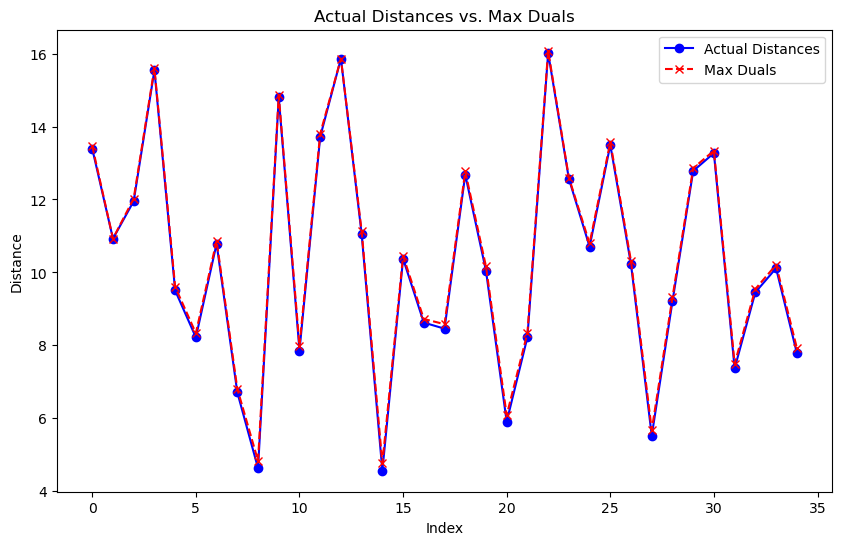

In [42]:
# Plotting them against their indices
plt.figure(figsize=(10, 6))  # Set the figure size

# Scatter plot for actual_distances vs. max_duals by index
plt.plot(actual_distances, label='Actual Distances', marker='o', linestyle='-', color='blue')
plt.plot(max_duals, label='Max Duals', marker='x', linestyle='--', color='red')

# Adding labels and legend
plt.xlabel('Index')
plt.ylabel('Distance')
plt.title('Actual Distances vs. Max Duals')
plt.legend()

# Show plot
plt.show()

## Plot differences

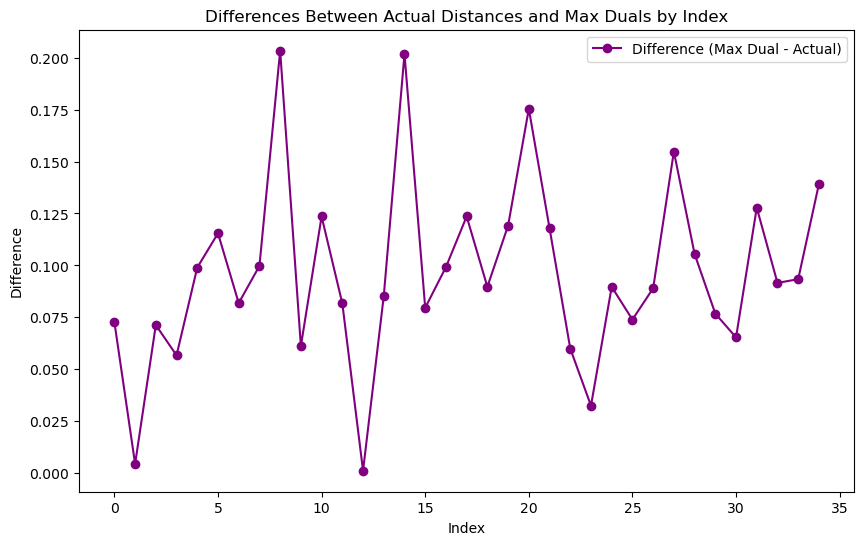

In [43]:
# Calculate the differences
differences = [max_dual-actual for actual, max_dual in zip(actual_distances, max_duals)]

# Plot the differences by index
plt.figure(figsize=(10, 6))
plt.plot(differences, marker='o', linestyle='-', color='purple', label='Difference (Max Dual - Actual)')

# Adding labels and legend
plt.xlabel('Index')
plt.ylabel('Difference')
plt.title('Differences Between Actual Distances and Max Duals by Index')
plt.legend()

# Show plot
plt.show()

## Joint Plot

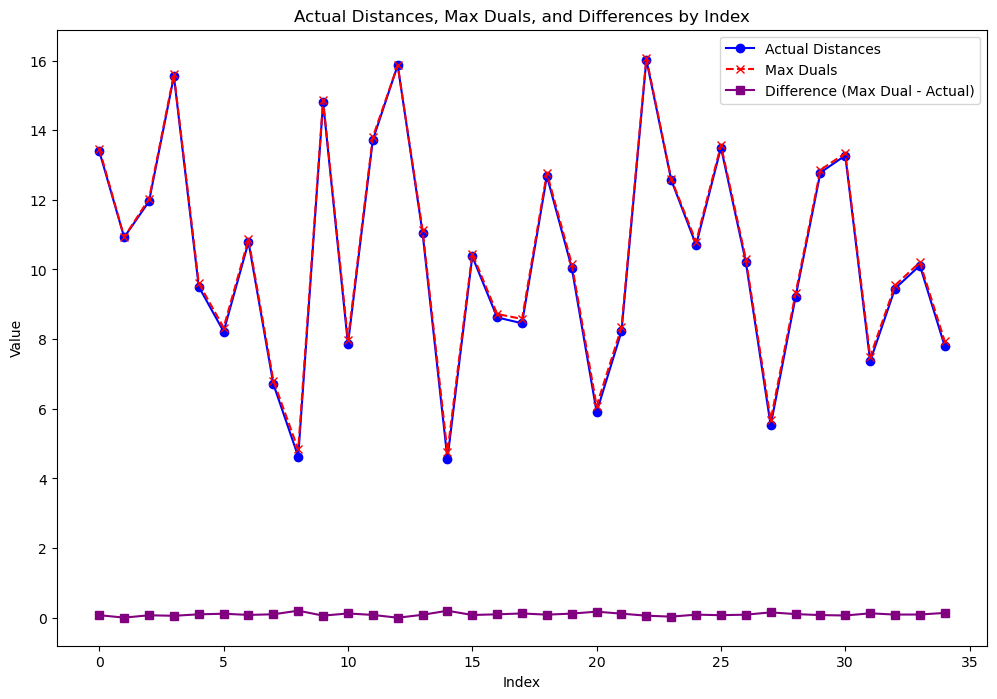

In [44]:
def plot_actual_vs_daul_maxes(actual_distances,max_duals):
    plt.figure(figsize=(12, 8))

    # Plot actual_distances and max_duals
    plt.plot(actual_distances, label='Actual Distances', marker='o', linestyle='-', color='blue',markersize = 6)
    plt.plot(max_duals, label='Max Duals', marker='x', linestyle='--', color='red',markersize = 6)
    # Calculate the differences
    differences = [max_dual-actual for actual, max_dual in zip(actual_distances, max_duals)]
    # Plot the differences
    plt.plot(differences, label='Difference (Max Dual - Actual)', marker='s', linestyle='-', color='purple',markersize = 6)
    
    # Adding labels, title, and legend
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Actual Distances, Max Duals, and Differences by Index')
    plt.legend()
    
    # Show plot
    plt.show()

plot_actual_vs_daul_maxes(actual_distances,max_duals)

In [50]:
torch.mean(torch.tensor(differences)),torch.max(torch.tensor(differences))

(tensor(0.0961), tensor(0.2033))

In [51]:
torch.mean(torch.tensor(actual_distances))

tensor(10.3531)

In [52]:
torch.mean(torch.tensor(max_duals))

tensor(10.4492)

In [55]:
def dual_projection_og(f, g, cost):
    """
    Perform dual projection to obtain f_ret and g_ret.
    
    Parameters:
    f (torch.Tensor): A 1D tensor with the f values.
    g (torch.Tensor): A 1D tensor with the g values.
    cost (torch.Tensor): A 2D tensor with cost values where cost[i][k] is the cost value.

    Returns:
    torch.Tensor: f_ret tensor.
    torch.Tensor: g_ret tensor.
    """
    # Compute g_ret (which is simply g)
    g_ret = g.clone()
    
    # Compute the cost matrix subtraction
    cost_minus_g = cost - g.unsqueeze(1)  # Broadcasting to subtract g from each column in cost
    
    # Compute min_over_k(cost[i][k] - g[k])
    min_cost_minus_g = torch.min(cost_minus_g, dim=1).values
    
    # Compute f_ret
    f_ret = torch.minimum(f, min_cost_minus_g)
    
    return f_ret, g_ret

def dual_sol_og(f, g, distances_mat):
    projected_f, projected_g = dual_projection_og(f=f, g=g, cost=(distances_mat**2))  # Changed distances to squared
    sum_result = torch.sum(projected_f + projected_g)
    max_val = torch.maximum(sum_result, torch.tensor(0.0))  # Take the max of the sum and zero
    return torch.sqrt(max_val)

In [56]:
start_time = time.time()
fouls = stress_random_check(dual_sol_func=dual_sol_og,
                            primal_sol_func=primal_sol,
                            num_samples=200,
                            trials_per_sample=300)
print("Time taken:", time.time() - start_time)

Time taken: 93.43736362457275


In [57]:
actual_distances = [foul[2].cpu() for foul in fouls]
max_duals  = [foul[3] for foul in fouls]
len(actual_distances)

0

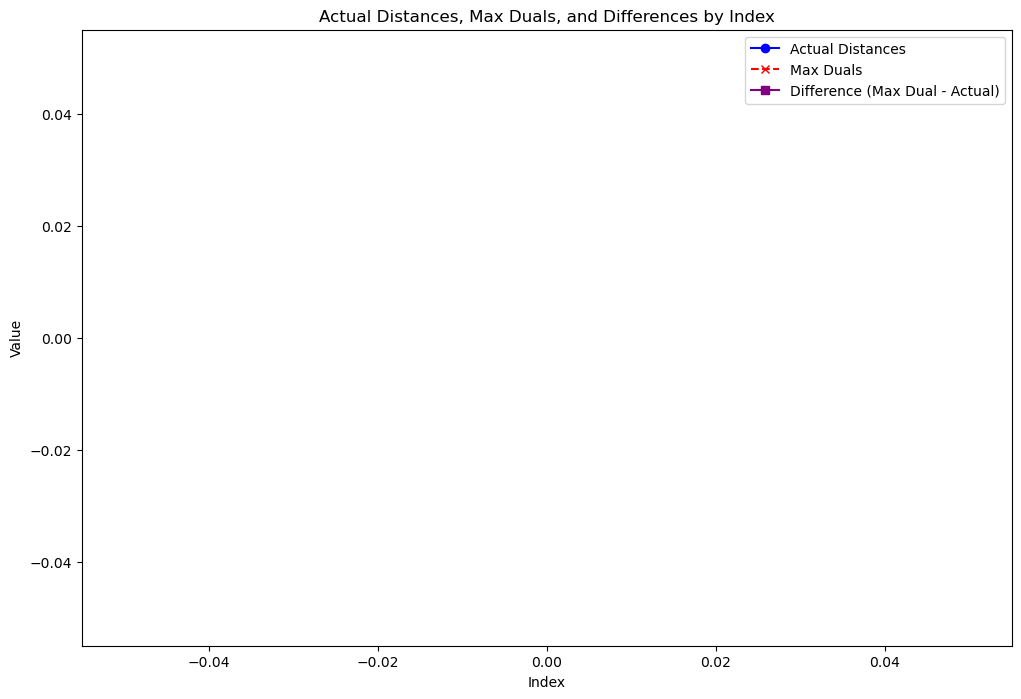

In [58]:
plot_actual_vs_daul_maxes(actual_distances,max_duals)